#  TensorFlow Distributed Training Options 

Sometimes it makes sense to perform training on a single machine. For large datasets, however, it may be necessary to perform distributed training on a cluster of multiple machines. Cluster managment often is a pain point in the machine learning pipeline. Fortunately, Amazon SageMaker makes it easy to run distributed training without having to manage cluster setup and tear down. In this notebook, we'll examine some different options for performing distributed training with TensorFlow in Amazon SageMaker. In particular, we'll look at the following options:

- **Parameter Servers**: processes that receive asynchronous updates from worker nodes and distribute updated gradients to all workers.

- **Horovod**:  a framework based on Ring-AllReduce wherein worker nodes synchronously exchange gradient updates only with two other workers at a time.  

The model used for this notebook is a basic Convolutional Neural Network (CNN) based on [the Keras examples](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py), although we will be using the tf.keras implementation of Keras rather than the separate Keras reference implementation.  We'll train the CNN to classify images using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), a well-known computer vision dataset. It consists of 60,000 32x32 images belonging to 10 different classes, with 6,000 images per class. Here is a graphic of the classes in the dataset, as well as 10 random images from each:

![cifar10](https://maet3608.github.io/nuts-ml/_images/cifar10.png)


## Setup 

We'll begin with some necessary imports, and get an Amazon SageMaker session to help perform certain tasks, as well as an IAM role with the necessary permissions.

In [1]:
%matplotlib inline
import numpy as np
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-tf-distribution-options'
print('Bucket:\n{}'.format(bucket))

Bucket:
sagemaker-us-east-1-149669388636


Now we'll run a script that fetches the dataset and converts it to the TFRecord format, which provides several conveniences for training models in TensorFlow.

In [2]:
!python generate_cifar10_tfrecords.py --data-dir ./data



Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract.
Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.
Generating ./data/train/train.tfrecords
Generating ./data/validation/validation.tfrecords
Generating ./data/eval/eval.tfrecords
Done!


For Amazon SageMaker hosted training on a cluster separate from this notebook instance, training data must be stored in Amazon S3, so we'll upload the data to S3 now.

In [3]:
inputs = sagemaker_session.upload_data(path='data', key_prefix='data/tf-distribution-options')
display(inputs)

's3://sagemaker-us-east-1-149669388636/data/tf-distribution-options'

## Distributed Training with Parameter Servers

A common pattern in distributed training is to use dedicated processes to collect gradients computed by “worker” processes, then aggregate them and distribute the updated gradients back to the workers. These processes are known as parameter servers. In general, they can be run either on their own machines or co-located on the same machines as the workers. In a parameter server cluster, each parameter server communicates with all workers (“all-to-all”). The Amazon SageMaker prebuilt TensorFlow container comes with a built-in option to use parameter servers for distributed training. The container runs a parameter server thread in each training instance, so there is a 1:1 ratio of parameter servers to workers. With this built-in option, gradient updates are made asynchronously (though some other versions of parameters servers use synchronous updates). 

Script Mode requires a training script, which in this case is the `train_ps.py` file in the */code* subdirectory of the [related distributed training example GitHub repository](https://github.com/aws-samples/amazon-sagemaker-script-mode/tree/master/tf-distribution-options).  Once a training script is ready, the next step is to set up an Amazon SageMaker TensorFlow Estimator object with the details of the training job.  It is very similar to an Estimator for training on a single machine, except we specify a `distributions` parameter to enable starting a parameter server on each training instance. We'll reference the GitHub repository so we can keep our training code version controlled and avoid downloading it locally.

In [6]:
from sagemaker.tensorflow import TensorFlow

ps_instance_type = 'ml.p3.2xlarge'
ps_instance_count = 2

model_dir = "/opt/ml/model"

distributions = {'parameter_server': {
                    'enabled': True}
                }
hyperparameters = {'epochs': 60, 'batch-size' : 256}

estimator_ps = TensorFlow(
                       source_dir='code',
                       entry_point='train_ps.py', 
                       base_job_name='ps-cifar10-tf',
                       role=role,
                       framework_version='1.13',
                       py_version='py3',
                       hyperparameters=hyperparameters,
                       train_instance_count=ps_instance_count, 
                       train_instance_type=ps_instance_type,
                       model_dir=model_dir,
                       tags = [{'Key' : 'Project', 'Value' : 'cifar10'},{'Key' : 'TensorBoard', 'Value' : 'dist'}],
                       distributions=distributions)

Now we can call the `fit` method of the Estimator object to start training. After training completes, the tf.keras model will be saved in the SavedModel .pb format so it can be served by a TensorFlow Serving container. Note that the model is only saved by the the lead node (disregard any warnings about the model not being saved by all the processes).

In [7]:
remote_inputs = {'train' : inputs+'/train', 'validation' : inputs+'/validation', 'eval' : inputs+'/eval'}
estimator_ps.fit(remote_inputs, wait=True)

2019-12-05 04:36:36 Starting - Starting the training job...
2019-12-05 04:36:37 Starting - Launching requested ML instances......
2019-12-05 04:37:43 Starting - Preparing the instances for training......
2019-12-05 04:39:00 Downloading - Downloading input data...
2019-12-05 04:39:36 Training - Training image download completed. Training in progress..2019-12-05 04:39:38,884 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-12-05 04:39:38,915 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2019-12-05 04:39:38,915 sagemaker_tensorflow_container.training INFO     Launching parameter server process
2019-12-05 04:39:38,915 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2019-12-05 04:39:39,313 sagemaker_tensorflow_container.training INFO     Launching worker process
2019-12-05 04:39:39,534 sagemaker-containers INFO     Imported framewor

Epoch 1/60
#015 1/78 [..............................] - ETA: 8:40 - loss: 4.0759 - acc: 0.0938#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 2:50 - loss: 4.0969 - acc: 0.1393#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 1:41 - loss: 3.5969 - acc: 0.1555#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010

#015 1/78 [..............................] - ETA: 9:48 - loss: 3.5197 - acc: 0.1328#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 3:13 - loss: 3.7865 - acc: 0.1328#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 1:53 - loss: 3.4293 - acc: 0.1422#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01

#015 1/78 [..............................] - ETA: 5s - loss: 1.5007 - acc: 0.4727#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 3s - loss: 1.5699 - acc: 0.4219#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 1.5524 - acc: 0.4242#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 3s - loss: 1.2052 - acc: 0.5625#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 3s - loss: 1.2680 - acc: 0.5638#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 2s - loss: 1.2561 - acc: 0.5578#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 6s - loss: 1.0823 - acc: 0.6133#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 4s - loss: 1.1062 - acc: 0.6055#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 1.1221 - acc: 0.5906#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 6s - loss: 1.0104 - acc: 0.6836#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 4s - loss: 1.0651 - acc: 0.6237#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 1.0641 - acc: 0.6172#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 3s - loss: 0.9589 - acc: 0.6719#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 3s - loss: 0.9944 - acc: 0.6484#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 2s - loss: 0.9469 - acc: 0.6727#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 5s - loss: 0.9660 - acc: 0.6641#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 3s - loss: 0.9056 - acc: 0.6719#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 0.8868 - acc: 0.6883#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 5s - loss: 0.9436 - acc: 0.6445#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 3s - loss: 0.8828 - acc: 0.6901#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 0.8462 - acc: 0.7031#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 3s - loss: 0.7063 - acc: 0.7695#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 2s - loss: 0.7761 - acc: 0.7500#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 2s - loss: 0.7791 - acc: 0.7430#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 6s - loss: 0.7977 - acc: 0.7305#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 3s - loss: 0.7689 - acc: 0.7526#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 0.7152 - acc: 0.7602#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 3s - loss: 0.7161 - acc: 0.7695#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 3s - loss: 0.6786 - acc: 0.7799#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 0.6813 - acc: 0.7766#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 3s - loss: 0.6283 - acc: 0.8008#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 3s - loss: 0.6394 - acc: 0.7930#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 2s - loss: 0.6479 - acc: 0.7859#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 3s - loss: 0.5672 - acc: 0.7969#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 3s - loss: 0.5467 - acc: 0.8099#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 2s - loss: 0.5831 - acc: 0.8031#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 3s - loss: 0.6446 - acc: 0.7891#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 3s - loss: 0.6219 - acc: 0.7995#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 2s - loss: 0.6172 - acc: 0.8055#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 6s - loss: 0.5894 - acc: 0.8047#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 4s - loss: 0.6539 - acc: 0.7839#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 0.6415 - acc: 0.7859#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 6s - loss: 0.5987 - acc: 0.7852#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 4s - loss: 0.5740 - acc: 0.7904#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 0.5909 - acc: 0.7984#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 6s - loss: 0.6590 - acc: 0.8047#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 4s - loss: 0.6289 - acc: 0.8021#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 0.6445 - acc: 0.7883#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 6s - loss: 0.6257 - acc: 0.7891#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 4s - loss: 0.5558 - acc: 0.8125#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 0.5551 - acc: 0.8047#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 6s - loss: 0.5192 - acc: 0.8125#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 4s - loss: 0.5116 - acc: 0.8177#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 0.5129 - acc: 0.8148#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 5s - loss: 0.5869 - acc: 0.7969#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 3s - loss: 0.5885 - acc: 0.7878#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 0.5561 - acc: 0.8016#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 6s - loss: 0.5197 - acc: 0.8281#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 4s - loss: 0.5149 - acc: 0.8242#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 0.5109 - acc: 0.8219#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#015 1/78 [..............................] - ETA: 6s - loss: 0.4474 - acc: 0.8672#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 3/78 [>.............................] - ETA: 4s - loss: 0.5315 - acc: 0.8320#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015 5/78 [>.............................] - ETA: 3s - loss: 0.5463 - acc: 0.8172#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

INFO:root:Test loss:0.5473165328686054
INFO:root:Test accuracy:0.8125
2019-12-05 04:43:48,185 sagemaker_tensorflow_container.training INFO     master algo-1 is down, stopping parameter server
2019-12-05 04:43:48,186 sagemaker_tensorflow_container.training WARNING  Your model will NOT be servable with SageMaker TensorFlow Serving container.The model artifact was not saved in the TensorFlow SavedModel directory structure:
https://www.tensorflow.org/guide/saved_model#structure_of_a_savedmodel_directory
2019-12-05 04:43:48,186 sagemaker-containers INFO     Reporting training SUCCESS
INFO:root:Test loss:0.5413568440156106
INFO:root:Test accuracy:0.8125
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:root:Model successfully saved at: /opt/ml/model
2019-12-05 04:43:54,080 sagemaker-containers INFO     Re

After training is complete, it is always a good idea to take a look at training curves to diagnose problems, if any, during training and determine the representativeness of the training and validation datasets.  We can do this with TensorBoard, and also with the Keras API: conveniently, the Keras `fit` invocation returns a data structure with the training history. In our training script, this history is saved on the lead training node, then uploaded with the model when training is complete.

To retrieve the history, we first download the model locally, then unzip it to gain access to the history data structure. We can then simply load the history as JSON:

In [8]:
import json 

!aws s3 cp {estimator_ps.model_data} ./ps_model/model.tar.gz
!tar -xzf ./ps_model/model.tar.gz -C ./ps_model

with open('./ps_model/ps_history.p', "r") as f:
    ps_history = json.load(f)

download: s3://sagemaker-us-east-1-149669388636/ps-cifar10-tf-2019-12-05-04-36-35-781/output/model.tar.gz to ps_model/model.tar.gz


Now we can plot the history with two graphs, one for accuracy and another for loss. Each graph shows the results for both the training and validation datasets. Although training is a stochastic process that can vary significantly between training jobs, overall you are likely to see that the training curves are converging smoothly and steadily to higher accuracy and lower loss, while the validation curves are more jagged. This is due to the validation dataset being relatively small and thus not as representative as the training dataset.

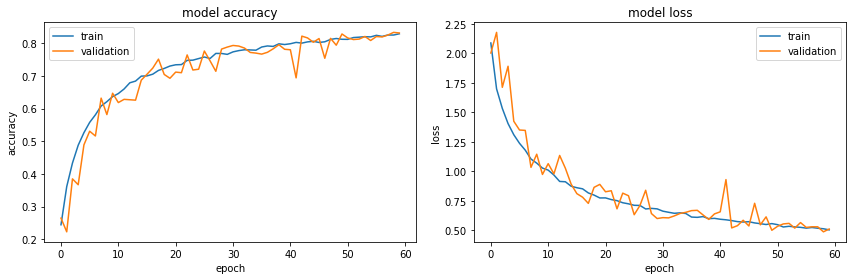

In [9]:
import matplotlib.pyplot as plt

def plot_training_curves(history): 
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    ax = axes[0]
    ax.plot(history['acc'], label='train')
    ax.plot(history['val_acc'], label='validation')
    ax.set(
        title='model accuracy',
        ylabel='accuracy',
        xlabel='epoch')
    ax.legend()

    ax = axes[1]
    ax.plot(history['loss'], label='train')
    ax.plot(history['val_loss'], label='validation')
    ax.set(
        title='model loss',
        ylabel='loss',
        xlabel='epoch')
    ax.legend()
    fig.tight_layout()
    
plot_training_curves(ps_history)

Besides saving the training history, we also can save other artifacts and data from the training job. For example, we can include a callback in the training script to save each model checkpoint after each training epoch is complete. These checkpoints will be saved to the same Amazon S3 folder as the model, in a zipped file named `output.tar.gz` as shown below:

In [10]:
artifacts_dir = estimator_ps.model_data.replace('model.tar.gz', '')
print(artifacts_dir)
!aws s3 ls --human-readable {artifacts_dir}

s3://sagemaker-us-east-1-149669388636/ps-cifar10-tf-2019-12-05-04-36-35-781/output/
2019-12-05 04:45:07    2.0 MiB model.tar.gz
2019-12-05 04:45:07  352.5 MiB output.tar.gz


## Distributed Training with Horovod

Horovod is an open source distributed training framework for TensorFlow, Keras, PyTorch, and MXNet. It is an alternative to the more "traditional" parameter servers method of performing distributed training demonstrated above.  Horovod can be more performant than parameter servers in large, GPU-based clusters where large models are trained. In Amazon SageMaker, Horovod is only available with TensorFlow version 1.12 or newer. 

Only a few lines of code are necessary to use Horovod for distributed training of a Keras model defined by the tf.keras API.  For details, see the `train_hvd.py` script included with this notebook; the changes primarily relate to:

- importing Horovod.
- initializing Horovod.
- configuring GPU options and setting a Keras/tf.session with those options.

The Estimator object for Horovod training is very similar to the parameter servers Estimator above, except we specify a `distributions` parameter describing Horovod attributes such as the number of process per host, which is set here to the number of GPUs per machine.  Beyond these few simple parameters and the few lines of code in the training script, there is nothing else you need to do to use distributed training with Horovod; Amazon SageMaker handles the heavy lifting for you and manages the underlying cluster setup.

In [11]:
from sagemaker.tensorflow import TensorFlow

hvd_instance_type = 'ml.p3.2xlarge'
hvd_processes_per_host = 1
hvd_instance_count = 2

distributions = {'mpi': {
                    'enabled': True,
                    'processes_per_host': hvd_processes_per_host,
                    'custom_mpi_options': '-verbose --NCCL_DEBUG=INFO -x OMPI_MCA_btl_vader_single_copy_mechanism=none'
                        }
                }

hyperparameters = {'epochs': 60, 'batch-size' : 256}

estimator_hvd = TensorFlow(
                       source_dir='code',
                       entry_point='train_hvd.py',
                       base_job_name='hvd-cifar10-tf', 
                       role=role,
                       framework_version='1.13',
                       py_version='py3',
                       hyperparameters=hyperparameters,
                       train_instance_count=hvd_instance_count, 
                       train_instance_type=hvd_instance_type,
                       tags = [{'Key' : 'Project', 'Value' : 'cifar10'},{'Key' : 'TensorBoard', 'Value' : 'dist'}],
                       distributions=distributions)

With these changes to the Estimator, we can call its `fit` method to start training. After training completes, the tf.keras model will be saved in the SavedModel .pb format so it can be served by a TensorFlow Serving container.  Note that the model is only saved by the the master, Horovod rank = 0 process (once again disregard any warnings about the model not being saved by all the processes).

In [12]:
remote_inputs = {'train' : inputs+'/train', 'validation' : inputs+'/validation', 'eval' : inputs+'/eval'}
estimator_hvd.fit(remote_inputs, wait=True)

2019-12-05 04:45:27 Starting - Starting the training job...
2019-12-05 04:45:28 Starting - Launching requested ML instances......
2019-12-05 04:46:30 Starting - Preparing the instances for training......
2019-12-05 04:47:52 Downloading - Downloading input data...
2019-12-05 04:48:08 Training - Downloading the training image..2019-12-05 04:48:31,723 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-12-05 04:48:32,085 sagemaker-containers INFO     Starting MPI run as worker node.
2019-12-05 04:48:32,085 sagemaker-containers INFO     Waiting for MPI Master to create SSH daemon.
2019-12-05 04:48:32,091 paramiko.transport INFO     Connected (version 2.0, client OpenSSH_7.2p2)
/usr/local/lib/python3.6/site-packages/paramiko/kex_ecdh_nist.py:39: CryptographyDeprecationWarning: encode_point has been deprecated on EllipticCurvePublicNumbers and will be removed in a future version. Please use EllipticCurvePublicKey.public_bytes to obtain both compresse


2019-12-05 04:48:28 Training - Training image download completed. Training in progress.[1,1]<stdout>:Epoch 1/60
[1,0]<stdout>:Epoch 1/60
[1,1]<stderr>:2019-12-05 04:48:43.630159: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally
[1,0]<stdout>:algo-1:53:77 [0] NCCL INFO NET/Socket : Using [0]eth0:10.0.225.76<0>
[1,0]<stdout>:algo-1:53:77 [0] NCCL INFO NET/Plugin : No plugin found (libnccl-net.so).
[1,0]<stdout>:
[1,0]<stdout>:algo-1:53:77 [0] misc/ibvwrap.cc:63 NCCL WARN Failed to open libibverbs.so[.1]
[1,0]<stdout>:NCCL version 2.4.7+cuda10.0
[1,1]<stdout>:algo-2:60:84 [0] NCCL INFO NET/Socket : Using [0]eth0:10.0.224.248<0>
[1,1]<stdout>:algo-2:60:84 [0] NCCL INFO NET/Plugin : No plugin found (libnccl-net.so).
[1,1]<stdout>:
[1,1]<stdout>:algo-2:60:84 [0] misc/ibvwrap.cc:63 NCCL WARN Failed to open libibverbs.so[.1]
[1,0]<stdout>:algo-1:53:77 [0] NCCL INFO Setting affinity for GPU 0 to ff
[1,1]<stdout>:algo-2:60:84 [0] NCCL IN

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 1.6495 - acc: 0.4023[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 19s - loss: 1.5555 - acc: 0.4219[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 2/78 [..............................] - ETA: 3s - loss: 1.5095 - acc: 0.4492[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>............

 loss: 1.1810 - acc: 0.5812[1,0]<stdout>:67/78 [========================>.....] - ETA: 0s - loss: 1.1876 - acc: 0.5720[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:68/78 [=========================>....] - ETA: 0s - loss: 1.1879 - acc: 0.5721[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:68/78 [=========================>....] - ETA: 0s - loss: 1.1811 - acc: 0.5811[1,0]<stdout>:#010#010#010#010#010#010#010#010#0

[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 20s - loss: 0.8834 - acc: 0.6758[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.8576 - acc: 0.7109[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 2/78 [..............................] - ETA: 11s - loss: 0.9643 - acc: 0.6582[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>...........

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.8481 - acc: 0.6797[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 19s - loss: 0.9716 - acc: 0.6367[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>.............................] - ETA: 8s - loss: 0.9340 - acc: 0.6680 [1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>...........

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.8139 - acc: 0.6914[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 21s - loss: 0.9052 - acc: 0.7031[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 0.8044 - acc: 0.7135[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>............

[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 18s - loss: 0.7393 - acc: 0.7461[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 4s - loss: 0.7371 - acc: 0.7500[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>.............................] - ETA: 8s - loss: 0.7306 - acc: 0.7539 [1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>...........

[1,0]<stdout>:#015[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 17s - loss: 0.7347 - acc: 0.7500[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.6732 - acc: 0.7539[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>.............................] - ETA: 8s - loss: 0.6854 - acc: 0.7760 [1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>...........

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 4s - loss: 0.6642 - acc: 0.7383[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 17s - loss: 0.6886 - acc: 0.7617[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 2/78 [..............................] - ETA: 4s - loss: 0.6522 - acc: 0.7578[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 2/78 [.............

[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 19s - loss: 0.5677 - acc: 0.7812[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.6551 - acc: 0.7617[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 0.6245 - acc: 0.7839[1,1]<stdout>: 3/78 [>............

[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 19s - loss: 0.7405 - acc: 0.7539[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.5673 - acc: 0.8438[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 0.6252 - acc: 0.7904[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>............

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.6076 - acc: 0.8047[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 32s - loss: 0.5325 - acc: 0.7969[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 0.6212 - acc: 0.8086[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>............

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 4s - loss: 0.5468 - acc: 0.8164[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 20s - loss: 0.5936 - acc: 0.7891[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>.............................] - ETA: 9s - loss: 0.5690 - acc: 0.7995 [1,0]<stdout>: 3/78 [>...........

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:71/78 [==========================>...] - ETA: 0s - loss: 0.5506 - acc: 0.8106[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:71/78 [==========================>...] - ETA: 0s - loss: 0.5491 - acc: 0.8120[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:72/78 [==========================>...] - ETA

[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 17s - loss: 0.6416 - acc: 0.8086[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.4676 - acc: 0.8398[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 0.5473 - acc: 0.8177[1,1]<stdout>: 3/78 [>............

[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 26s - loss: 0.4654 - acc: 0.8359[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.4410 - acc: 0.8516[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>.............................] - ETA: 11s - loss: 0.4621 - acc: 0.8333[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>...........

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.4763 - acc: 0.8438[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 20s - loss: 0.5543 - acc: 0.8047[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 2/78 [..............................] - ETA: 4s - loss: 0.5290 - acc: 0.8105[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 2/78 [.............

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.5178 - acc: 0.8281[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 18s - loss: 0.4850 - acc: 0.8242[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 0.5093 - acc: 0.8333[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>............

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.4470 - acc: 0.8516[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 16s - loss: 0.4572 - acc: 0.8242[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 0.4568 - acc: 0.8385[1,1]<stdout>: 3/78 [>............

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:75/78 [===========================>..] - ETA: 0s - loss: 0.4598 - acc: 0.8419[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:75/78 [===========================>..] - ETA: 0s - loss: 0.4571 - acc: 0.8436[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:77/78 [============================>

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.5408 - acc: 0.8086[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 23s - loss: 0.4013 - acc: 0.8477[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 0.4757 - acc: 0.8385[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>............

[1,1]<stdout>:#015[1,0]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 18s - loss: 0.3860 - acc: 0.8750[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.4663 - acc: 0.8086[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 2/78 [..............................] - ETA: 4s - loss: 0.4937 - acc: 0.8184[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 2/78 [.............

[1,0]<stdout>:#015[1,1]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.4578 - acc: 0.8477[1,1]<stdout>: 1/78 [..............................] - ETA: 21s - loss: 0.4522 - acc: 0.8125[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>.............................] - ETA: 9s - loss: 0.4473 - acc: 0.8333 [1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>...........

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.3619 - acc: 0.8750[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 17s - loss: 0.4097 - acc: 0.8359[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>.............................] - ETA: 8s - loss: 0.4224 - acc: 0.8398 [1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>...........

[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 20s - loss: 0.3474 - acc: 0.8672[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.5400 - acc: 0.8359[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>.............................] - ETA: 9s - loss: 0.3717 - acc: 0.8581 [1,0]<stdout>: 3/78 [>...........

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.4673 - acc: 0.8125[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 18s - loss: 0.4553 - acc: 0.8438[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>.............................] - ETA: 8s - loss: 0.4152 - acc: 0.8620 [1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>...........

[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 17s - loss: 0.4348 - acc: 0.8555[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.4015 - acc: 0.8633[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 2/78 [..............................] - ETA: 10s - loss: 0.4226 - acc: 0.8555[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>.......

[1,1]<stderr>:INFO:root:Test loss:0.4631626865802667
[1,1]<stderr>:INFO:root:Test accuracy:0.8430488705635071
[1,0]<stderr>:INFO:root:Test loss:0.46239434755765474
[1,0]<stderr>:INFO:root:Test accuracy:0.8429487347602844
[1,0]<stdout>:
[1,0]<stdout>:WARNING: The TensorFlow contrib module will not be included in TensorFlow 2.0.
[1,0]<stdout>:For more information, please see:
[1,0]<stdout>:  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
[1,0]<stdout>:  * https://github.com/tensorflow/addons
[1,0]<stdout>:If you depend on functionality not listed there, please file an issue.
[1,0]<stdout>:
[1,0]<stderr>:INFO:root:Model successfully saved at: /opt/ml/model
2019-12-05 04:53:30,822 sagemaker-containers INFO     Reporting training SUCCESS
2019-12-05 04:54:00,854 sagemaker-containers INFO     MPI process finished.
2019-12-05 04:54:00,854 sagemaker_tensorflow_container.training WARNING  Your model will NOT be servable with SageMaker TensorFlow Serving con

We can now plot training curves for the Horovod training job similar to the curves we plotted for the parameter servers training job:

download: s3://sagemaker-us-east-1-149669388636/hvd-cifar10-tf-2019-12-05-04-45-26-200/output/model.tar.gz to hvd_model/model.tar.gz


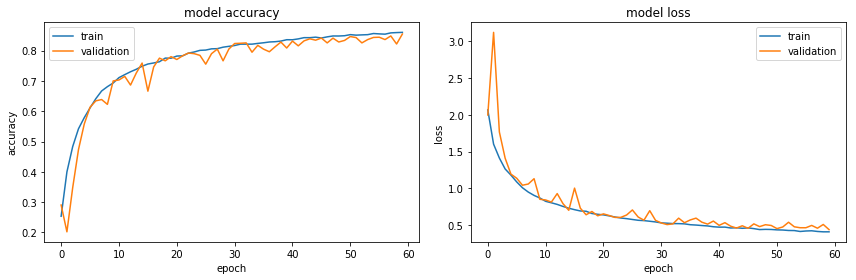

In [13]:
!aws s3 cp {estimator_hvd.model_data} ./hvd_model/model.tar.gz
!tar -xzf ./hvd_model/model.tar.gz -C ./hvd_model

with open('./hvd_model/hvd_history.p', "r") as f:
    hvd_history = json.load(f)
    
plot_training_curves(hvd_history)

## Comparing Results from Parameter Servers and Horovod

Now that both training jobs are complete, we can compare the results.  The CIFAR-10 dataset is relatively small so the training jobs do not run long enough to draw detailed conclusions. However, it is likely that you can observe some differences even though training time was short, and training is a stochastic process with different results every time. The training time can be approximated for our purposes by looking at the "Billable seconds" log output at the end of each training job (at the bottom of the log output beneath the `fit` invocation code cells).

The Horovod training job tends to take a bit longer than the parameter server training job, while producing a somewhat more accurate model. The relative speed result is consistent with research showing that Horovod is more performant for larger clusters and models, while parameter servers have the edge for smaller clusters and models such as this one. Also, asynchronous model updates like those used by the parameter servers here require more epochs to converge to more accurate models, so it is not surprising if the parameter server model training completed faster for the same number of epochs as Horovord, but was less accurate. It also is likely that you can observe that the training curves for the Horovod training job are a bit smoother, reflecting the fact that synchronous gradient updates typically are less noisy than asynchronous updates.

Typically, the performance significantly depends on how long it takes to share gradient updates during training. In turn, this is affected by the model size, gradients size, GPU specifications, and network speed.  Complexity is another consideration. Parameter servers are straightforward to use for one GPU per instance. However, to use multi-GPU instances, you must set up multiple towers, with each tower assigned to a different GPU. A “tower” is a function for computing inference and gradients for a single model replica, which in turn is a copy of a model training on a subset of the complete dataset. Towers involve a form of data parallelism. Horovod also employs data parallelism but abstracts away the implementation details.

Finally, cluster size makes a difference. Given larger clusters with many GPUs, parameter server all-to-all communication can overwhelm network bandwidth. Reduced scaling efficiency can result, among other adverse effects. In such situations, you might find Horovod a better option.

# Extensions

Although we did not demonstrate them in this notebook, Amazon SageMaker provides additional ways to make distributed training more efficient and cost effective for very large datasets:

- **Sharding data**:  in this example we used one large TFRecord file containing the entire CIFAR-10 dataset, which is relatively small. However, larger datasets might require that you shard the data into multiple files, particularly if Pipe Mode is used (see below). Sharding may be accomplished by specifying an Amazon S3 data source as a [manifest file or ShardedByS3Key](https://docs.aws.amazon.com/sagemaker/latest/dg/API_S3DataSource.html). 

- **VPC training**:  performing Horovod training inside a VPC improves the network latency between nodes, leading to higher performance and stability of Horovod training jobs.

- **Pipe Mode**:  using [Pipe Mode](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html#your-algorithms-training-algo-running-container-inputdataconfig) reduces startup and training times.  Pipe Mode streams training data from S3 as a Linux FIFO directly to the algorithm, without saving to disk.  For a small dataset such as CIFAR-10, Pipe Mode does not provide any advantage, but for very large datasets where training is I/O bound rather than CPU/GPU bound, Pipe Mode can substantially reduce startup and training times.

- **Amazon FSx for Lustre and Amazon EFS**:  performance on large datasets in File Mode may be improved in some circumstances using either Amazon FSx for Lustre or Amazon EFS. For more details, please refer to the related [blog post](https://aws.amazon.com/blogs/machine-learning/speed-up-training-on-amazon-sagemaker-using-amazon-efs-or-amazon-fsx-for-lustre-file-systems).

- **Managed Spot Training**:  uses Amazon EC2 Spot instances to run training jobs instead of on-demand instances. Managed spot training can optimize the cost of training models up to 90% over on-demand instances. For further details, please refer to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html).

In [15]:
predictor = estimator_hvd.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge') 

----------------------------------------------------------------------------------------!

In [17]:
type(inputs)

str

In [19]:
import tensorflow as tf
writer = tf.python_io.TFRecordWriter(inputs)

In [21]:
reconstructed_images = []

record_iterator = tf.python_io.tf_record_iterator(path=inputs)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [23]:
for im in record_iterator:
    print(im)

In [31]:
featdef = {
        'image': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64),
    }

example = tf.parse_single_example(inputs, featdef)

In [36]:
import matplotlib.image as mpimg
img=mpimg.imread(featdef['image'])
imgplot = plt.imshow(img)

TypeError: Object does not appear to be a 8-bit string path or a Python file-like object

In [38]:
import Image

image = Image.open(featdef['image'])
image.show()


ModuleNotFoundError: No module named 'Image'

In [ ]:
sagemaker.Session().delete_endpoint(predictor.endpoint)